In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from lifelines import KaplanMeierFitter
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter

# Load the data
file_path = '/Users/winnietaiwo/Downloads/2025 HEOR ANALYST CASE STUDY/2025 HEOR ANALYST CASE STUDY.csv'
df = pd.read_csv(file_path)
    
# Initial data exploration
print("\nFirst 5 rows:")
print(df.head())
print("\nData summary:")
print(df.info())
print("\nDescriptive statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


First 5 rows:
   YEAR PATIENT_ID PATIENT_GENDER  PATIENT_YOB  PATIENT_AGE  \
0  2022   5WDRGNYM              F         1971           51   
1  2021   XYPPGJXG              M         1958           63   
2  2022   XYPPGJXG              M         1958           64   
3  2020   YK4V74GE              F         1967           53   
4  2021   YK4V74GE              F         1967           54   

      PATIENT_RACE_ETHNICITY  HCRU_HOSPITALIZATION  HCRU_STATUS_EPILEPTICUS  \
0  BLACK OR AFRICAN AMERICAN                     1                        0   
1                      WHITE                     0                        1   
2                      WHITE                     1                        0   
3  BLACK OR AFRICAN AMERICAN                     0                        0   
4  BLACK OR AFRICAN AMERICAN                     0                        0   

   HCRU_GTC  COMORBID_MYOCARDIAL_INFARCTION  ...  COMORBID_ANY_MALIGNANCY  \
0         0                               0  ...      

In [2]:
# Combine CSA and OSA into single category
df['SLEEP_APNEA'] = df['COMORBID_APNEA_CLASSIFICATION'].replace({
    'CSA': 'SA',  # Central Sleep Apnea → Sleep Apnea
    'OSA': 'SA',   # Obstructive Sleep Apnea → Sleep Apnea
    'NSA': 'NSA'   # No Sleep Apnea remains unchanged
})

# Verify the combination
print("Value counts after combining:")
print(df['SLEEP_APNEA'].value_counts())

Value counts after combining:
SLEEP_APNEA
NSA    2154322
SA      342686
Name: count, dtype: int64


In [3]:
# 1. Calculate overall mortality rates and SMRs
mortality_summary = df.groupby('SLEEP_APNEA').agg(
    patient_count=('PATIENT_ID', 'count'),
    observed_deaths=('DEATH', 'sum'),
    expected_deaths=('SSA_DEATH_PROBABILITY', 'sum')
).reset_index()

mortality_summary['mortality_rate'] = mortality_summary['observed_deaths'] / mortality_summary['patient_count']
mortality_summary['SMR'] = mortality_summary['observed_deaths'] / mortality_summary['expected_deaths']

# 2. Age-stratified analysis
df['AGE_GROUP'] = pd.cut(df['PATIENT_AGE'], 
                        bins=[0, 18, 40, 65, 100],
                        labels=['<18', '18-39', '40-64', '65+'])

age_stratified = df.groupby(['SLEEP_APNEA', 'AGE_GROUP']).agg(
    patient_count=('PATIENT_ID', 'count'),
    observed_deaths=('DEATH', 'sum'),
    expected_deaths=('SSA_DEATH_PROBABILITY', 'sum')
).reset_index()

age_stratified['mortality_rate'] = age_stratified['observed_deaths'] / age_stratified['patient_count']
age_stratified['SMR'] = age_stratified['observed_deaths'] / age_stratified['expected_deaths']

# 3. Format and display results
print("Overall Mortality Rates and SMRs:")
print(mortality_summary[['SLEEP_APNEA', 'patient_count', 'observed_deaths', 
                        'expected_deaths', 'mortality_rate', 'SMR']].to_string(index=False))

print("\nAge-Stratified Analysis:")
print(age_stratified[['SLEEP_APNEA', 'AGE_GROUP', 'patient_count', 
                     'observed_deaths', 'expected_deaths', 
                     'mortality_rate', 'SMR']].to_string(index=False))

/var/folders/jv/shrbxd7568l14rtt0rvh4z1c0000gn/T/ipykernel_22963/1353750289.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_stratified = df.groupby(['SLEEP_APNEA', 'AGE_GROUP']).agg(


Overall Mortality Rates and SMRs:
SLEEP_APNEA  patient_count  observed_deaths  expected_deaths  mortality_rate      SMR
        NSA        2154322            56380     17290.020153        0.026171 3.260841
         SA         342686            12287      3732.622498        0.035855 3.291787

Age-Stratified Analysis:
SLEEP_APNEA AGE_GROUP  patient_count  observed_deaths  expected_deaths  mortality_rate       SMR
        NSA       <18         443375             1880       106.331624        0.004240 17.680535
        NSA     18-39         678834             6434      1044.381493        0.009478  6.160584
        NSA     40-64         696010            21586      5047.635619        0.031014  4.276458
        NSA       65+         336103            26480     11091.671417        0.078785  2.387377
         SA       <18          60381              936        13.183893        0.015502 70.995722
         SA     18-39          59078              926       100.935843        0.015674  9.174144
   

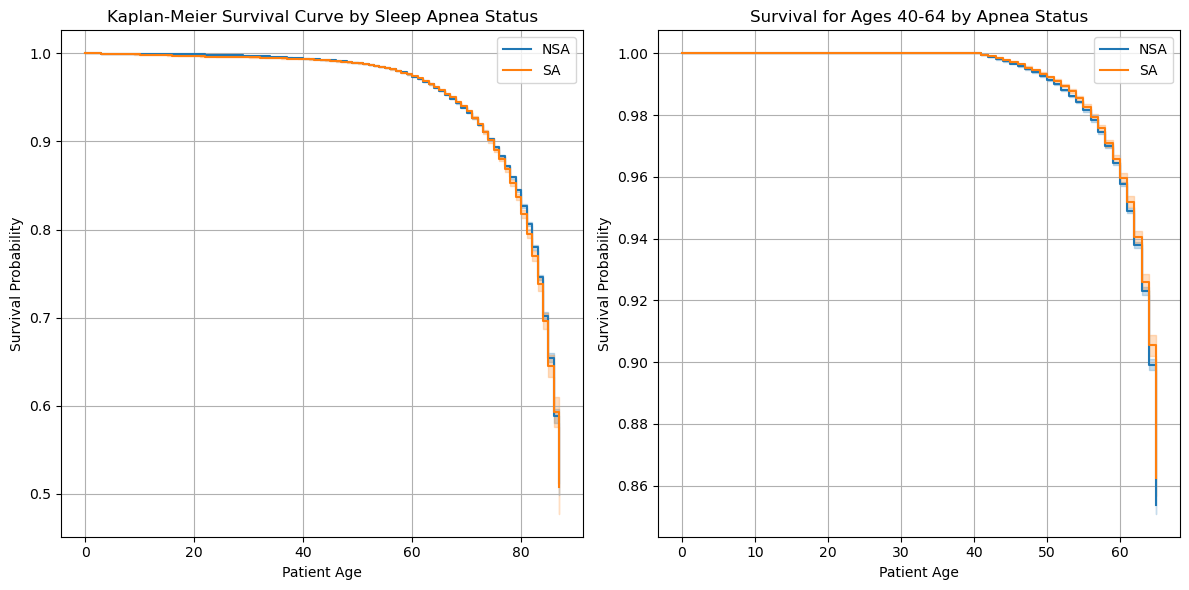

Log-rank test p-value: 0.0045


In [4]:
# Kaplan-Meier Analysis
plt.figure(figsize=(12, 6))

# Overall survival by apnea status
plt.subplot(1, 2, 1)
kmf = KaplanMeierFitter()

for name, grouped in df.groupby('SLEEP_APNEA'):
    kmf.fit(durations=grouped['PATIENT_AGE'],  # Using age as time metric
            event_observed=grouped['DEATH'],
            label=name)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by Sleep Apnea Status')
plt.xlabel('Patient Age')
plt.ylabel('Survival Probability')
plt.grid(True)

# Age-stratified survival
plt.subplot(1, 2, 2)
age_subset = df[df['AGE_GROUP'] == '40-64']

for name, grouped in age_subset.groupby('SLEEP_APNEA'):
    kmf.fit(durations=grouped['PATIENT_AGE'],
            event_observed=grouped['DEATH'],
            label=name)
    kmf.plot_survival_function()

plt.title('Survival for Ages 40-64 by Apnea Status')
plt.xlabel('Patient Age')
plt.ylabel('Survival Probability')
plt.grid(True)

plt.tight_layout()
plt.show()

# Log-rank test for statistical significance
from lifelines.statistics import logrank_test

results = logrank_test(
    durations_A=df[df['SLEEP_APNEA']=='SA']['PATIENT_AGE'],
    durations_B=df[df['SLEEP_APNEA']=='NSA']['PATIENT_AGE'],
    event_observed_A=df[df['SLEEP_APNEA']=='SA']['DEATH'],
    event_observed_B=df[df['SLEEP_APNEA']=='NSA']['DEATH']
)

print(f"Log-rank test p-value: {results.p_value:.4f}")


In [5]:
# significance testing 
# Define the age subsets
alive_ages = df[df['DEATH'] == 0]['PATIENT_AGE']
deceased_ages = df[df['DEATH'] == 1]['PATIENT_AGE']

# Check normality (with sampling for large datasets)
_, p_alive = stats.shapiro(alive_ages.sample(min(5000, len(alive_ages))))
_, p_deceased = stats.shapiro(deceased_ages.sample(min(5000, len(deceased_ages))))

print(f"Normality p-value (alive): {p_alive:.4f}")
print(f"Normality p-value (deceased): {p_deceased:.4f}")

# Choose the appropriate test
if p_alive < 0.05 or p_deceased < 0.05:
    print("Data is non-normal → Use Mann-Whitney U test")
    stat, p = stats.mannwhitneyu(alive_ages, deceased_ages)
else:
    print("Data is normal → Use t-test")
    stat, p = stats.ttest_ind(alive_ages, deceased_ages)

print(f"\nTest p-value: {p:.4e}")
print(f"Median age (alive): {alive_ages.median():.1f} vs deceased: {deceased_ages.median():.1f}")

Normality p-value (alive): 0.0000
Normality p-value (deceased): 0.0000
Data is non-normal → Use Mann-Whitney U test

Test p-value: 0.0000e+00
Median age (alive): 40.0 vs deceased: 64.0


Comparison of Patient Characteristics by Mortality Status:


,Variable,Type,Test,P-value,Effect Size,Alive,Deceased
0,SLEEP_APNEA,categorical,Chi-square,2.123246e-227,OR=1.38,{'NSA': 0.8639404432902957...,"{'NSA': 0.821063975417595,..."
1,PATIENT_AGE,continuous,Mann-Whitney U,0.000000e+00,CLES=0.24,{'mean': 40.37809228605043...,{'mean': 60.38742044941529...
2,PATIENT_GENDER,categorical,Chi-square,5.192308e-90,OR=1.17,"{'F': 0.5037690340854106, ...","{'M': 0.5351624506677152, ..."
3,CCI,continuous,Mann-Whitney U,0.000000e+00,CLES=0.22,{'mean': 2.957126696785995...,{'mean': 6.463454060902617...
4,HCRU_HOSPITALIZATION,binary,Chi-square,0.000000e+00,OR=1.68,"{0: 0.6656108017778393, 1:...","{0: 0.5421381449604613, 1:..."
5,COMORBID_DIABETES_WITH_CHR...,binary,Chi-square,0.000000e+00,OR=3.22,"{0: 0.8841105923756177, 1:...","{0: 0.703190761209897, 1: ..."
6,COMORBID_CEREBROVASCULAR_D...,binary,Chi-square,0.000000e+00,OR=3.47,"{0: 0.7098401748354123, 1:...","{1: 0.5863660856015263, 0:..."
7,PATIENT_RACE_ETHNICITY,categorical,Chi-square,0.000000e+00,N/A,{'WHITE': 0.45350797107984...,{'WHITE': 0.55853612361105...


/var/folders/jv/shrbxd7568l14rtt0rvh4z1c0000gn/T/ipykernel_22963/3258491539.py:109: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='SLEEP_APNEA', y='DEATH', data=df, estimator=np.mean, ci=None)
/var/folders/jv/shrbxd7568l14rtt0rvh4z1c0000gn/T/ipykernel_22963/3258491539.py:125: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='HCRU_HOSPITALIZATION', y='DEATH', data=df, estimator=np.mean, ci=None)


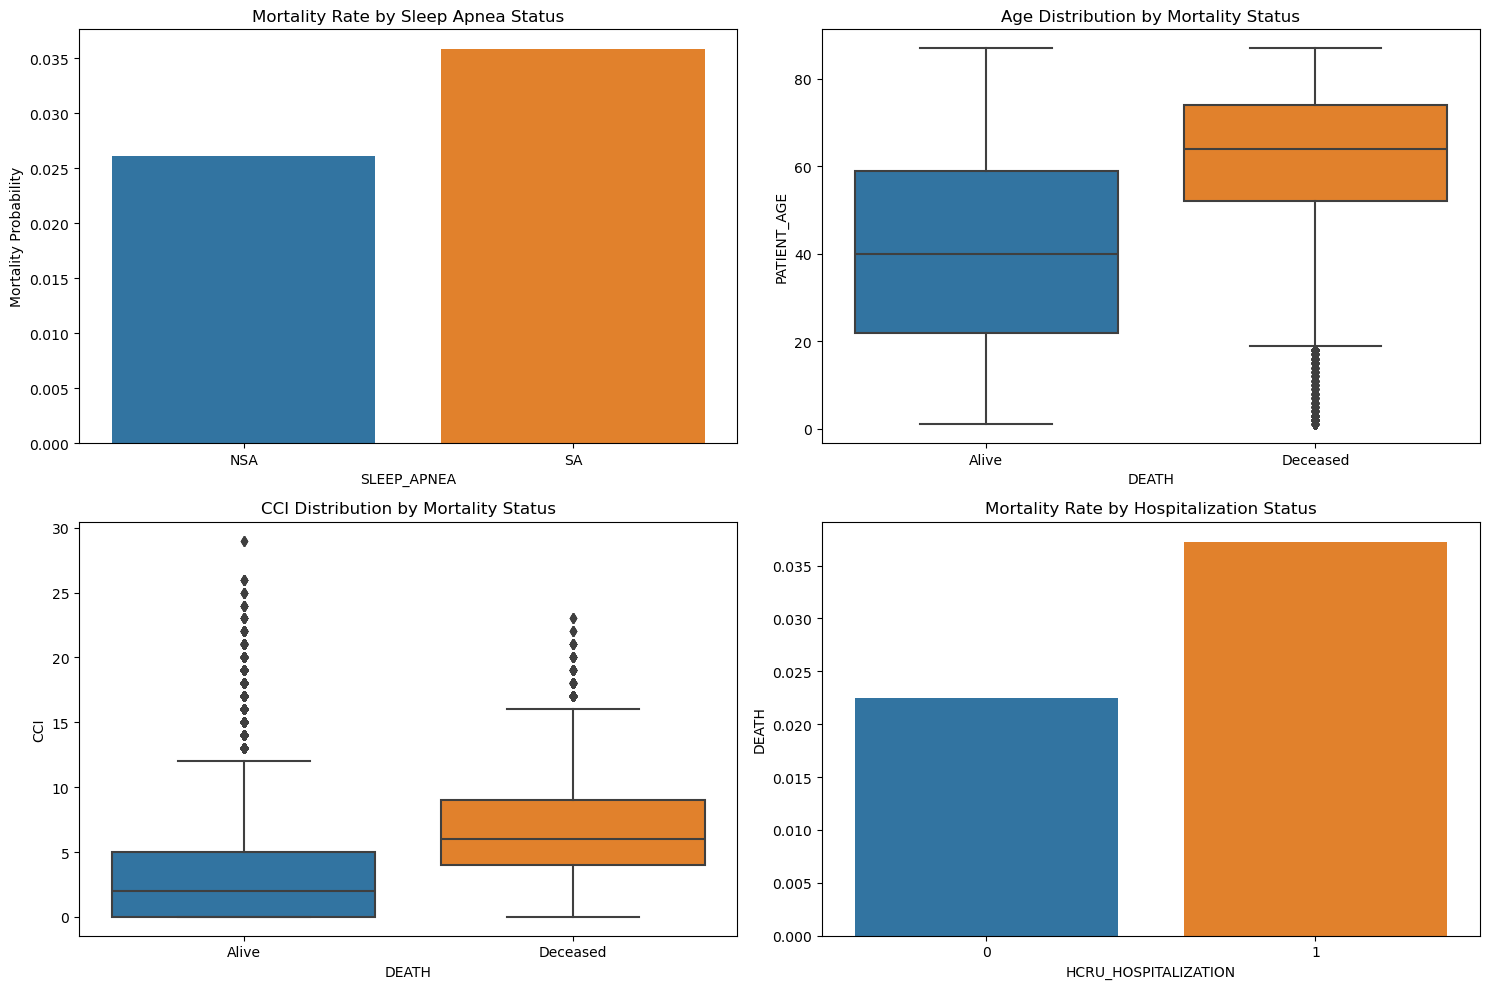

In [6]:
# Comparison of Patient Variables Between Survivors and Non-Survivors
# Select key variables to compare
variables = {
    'SLEEP_APNEA': 'categorical',  # primary variable of interest
    'PATIENT_AGE': 'continuous',
    'PATIENT_GENDER': 'categorical',
    'CCI': 'continuous',           # Charlson Comorbidity Index
    'HCRU_HOSPITALIZATION': 'binary',
    'COMORBID_DIABETES_WITH_CHRONIC_COMPLICATIONS': 'binary',
    'COMORBID_CEREBROVASCULAR_DISEASE': 'binary',
    'PATIENT_RACE_ETHNICITY': 'categorical'
}

# Initialize results storage
results = []

# Perform appropriate tests for each variable
for var, var_type in variables.items():
    
    # Skip if variable not in dataframe
    if var not in df.columns:
        continue
        
    # --- Categorical/Binary Variables ---
    if var_type in ['categorical', 'binary']:
        # Create contingency table
        contingency = pd.crosstab(df['DEATH'], df[var])
        
        # Fisher's exact test if any cell count <5, else Chi-square
        if (contingency < 5).any().any():
            _, p = stats.fisher_exact(contingency)
            test = "Fisher's exact"
        else:
            chi2, p, _, _ = stats.chi2_contingency(contingency)
            test = "Chi-square"
        
        # Calculate proportions
        prop_deceased = df[df['DEATH']==1][var].value_counts(normalize=True).to_dict()
        prop_alive = df[df['DEATH']==0][var].value_counts(normalize=True).to_dict()
        
        # Store effect size (Odds Ratio for binary variables)
        if len(contingency.columns) == 2 and len(contingency.index) == 2:
            a, b = contingency.iloc[1,1], contingency.iloc[1,0]
            c, d = contingency.iloc[0,1], contingency.iloc[0,0]
            OR = (a/b)/(c/d)
            effect_size = f"OR={OR:.2f}"
        else:
            effect_size = "N/A"
    
    # --- Continuous Variables ---
    elif var_type == 'continuous':
        # Split into groups
        alive = df[df['DEATH']==0][var].dropna()
        deceased = df[df['DEATH']==1][var].dropna()
        
        # Check normality (with sampling for large datasets)
        _, p_alive = stats.shapiro(alive.sample(min(5000, len(alive))))
        _, p_deceased = stats.shapiro(deceased.sample(min(5000, len(deceased))))
        
        # Select test based on normality
        if p_alive < 0.05 or p_deceased < 0.05:
            # Non-parametric test
            stat, p = stats.mannwhitneyu(alive, deceased)
            test = "Mann-Whitney U"
            effect_size = f"CLES={(stat/(len(alive)*len(deceased))):.2f}"  
        else:
            # Parametric test
            stat, p = stats.ttest_ind(alive, deceased)
            test = "T-test"
            effect_size = f"Cohen's d={abs(stat)/np.sqrt(len(alive)+len(deceased)):.2f}"
        
        # Store summary statistics
        prop_alive = {
            'mean': np.mean(alive),
            'median': np.median(alive),
            'IQR': stats.iqr(alive)
        }
        prop_deceased = {
            'mean': np.mean(deceased),
            'median': np.median(deceased),
            'IQR': stats.iqr(deceased)
        }
    
    # Store results
    results.append({
        'Variable': var,
        'Type': var_type,
        'Test': test,
        'P-value': p,
        'Effect Size': effect_size,
        'Alive': prop_alive,
        'Deceased': prop_deceased
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 30)

print("Comparison of Patient Characteristics by Mortality Status:")
display(results_df[['Variable', 'Type', 'Test', 'P-value', 'Effect Size', 'Alive', 'Deceased']])

# Visualization of key variables
plt.figure(figsize=(15, 10))

# Plot 1: Sleep Apnea Prevalence
plt.subplot(2, 2, 1)
sns.barplot(x='SLEEP_APNEA', y='DEATH', data=df, estimator=np.mean, ci=None)
plt.title('Mortality Rate by Sleep Apnea Status')
plt.ylabel('Mortality Probability')

# Plot 2: Age Distribution
plt.subplot(2, 2, 2)
sns.boxplot(x='DEATH', y='PATIENT_AGE', data=df.assign(DEATH=df['DEATH'].map({0:'Alive', 1:'Deceased'})))
plt.title('Age Distribution by Mortality Status')

# Plot 3: CCI Distribution
plt.subplot(2, 2, 3)
sns.boxplot(x='DEATH', y='CCI', data=df.assign(DEATH=df['DEATH'].map({0:'Alive', 1:'Deceased'})))
plt.title('CCI Distribution by Mortality Status')

# Plot 4: Hospitalization Rate
plt.subplot(2, 2, 4)
sns.barplot(x='HCRU_HOSPITALIZATION', y='DEATH', data=df, estimator=np.mean, ci=None)
plt.title('Mortality Rate by Hospitalization Status')

plt.tight_layout()
plt.show()

In [7]:
#4. Build a Cox Proportional Hazards Model

# Copy the dataframe
cox_df = df.copy()

# Map gender and sleep apnea manually to binary
cox_df['PATIENT_GENDER'] = cox_df['PATIENT_GENDER'].map({'M': 1, 'F': 0})
cox_df['SLEEP_APNEA'] = cox_df['SLEEP_APNEA'].map({'SA': 1, 'NSA': 0})

# One-hot encode race
cox_df = pd.get_dummies(cox_df, columns=['PATIENT_RACE_ETHNICITY'], drop_first=True)

# Select features
features = [
    'PATIENT_AGE', 
    'PATIENT_GENDER', 
    'SLEEP_APNEA',
    'CCI', 
    'HCRU_HOSPITALIZATION',
    'COMORBID_DIABETES_WITH_CHRONIC_COMPLICATIONS',
    'COMORBID_CEREBROVASCULAR_DISEASE'
] + [col for col in cox_df.columns if col.startswith('PATIENT_RACE_ETHNICITY_')]

# Fit the Cox model
cph = CoxPHFitter()
cph.fit(cox_df[features + ['DEATH']], duration_col='PATIENT_AGE', event_col='DEATH')

# Print summary
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 2.49701e+06 total observations, 2.42834e+06 right-censored observations>
             duration col = 'PATIENT_AGE'
                event col = 'DEATH'
      baseline estimation = breslow
   number of observations = 2.49701e+06
number of events observed = 68667
   partial log-likelihood = -874343.58
         time fit was run = 2025-04-29 21:55:24 UTC

---
                                                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                
PATIENT_GENDER                                     0.26       1.29       0.01             0.24             0.27                 1.27                 1.31
SLEEP_APNEA                                        0.04       1.04       0.01             0.02             0.06                 1.02                 1.06
CCI                                               -0.05       0.96       0.00            -0.05            -0.04                 0.95                 0.96
HCRU_HOSPITALIZATION                               0.65       1.92       0.01             0.64             0.67                 1.89                 1.95
COMORBID_DIABETES_WITH_CHRONIC_COMPLICATIONS       0.26       1.29       0.01             0.24             0.28                 1.27                 1.32
COMORBID_CEREBROVASCULAR_DISEASE                  -0.03       0.97       0.01            -0.05            -0.01                 0.95                 0.99
PATIENT_RACE_ETHNICITY_BLACK OR AFRICAN AMERICAN   0.47       1.60       0.03             0.41             0.53                 1.50                 1.70
PATIENT_RACE_ETHNICITY_HISPANIC OR LATINO          0.09       1.09       0.03             0.02             0.15                 1.02                 1.16
PATIENT_RACE_ETHNICITY_OTHER                       0.48       1.62       0.04             0.41             0.56                 1.51                 1.75
PATIENT_RACE_ETHNICITY_UNKNOWN                     0.94       2.56       0.03             0.88             1.01                 2.40                 2.73
PATIENT_RACE_ETHNICITY_WHITE                       0.38       1.47       0.03             0.32             0.45                 1.38                 1.56

                                                   cmp to      z      p   -log2(p)
covariate                                                                         
PATIENT_GENDER                                       0.00  33.26 <0.005     803.32
SLEEP_APNEA                                          0.00   3.49 <0.005      11.01
CCI                                                  0.00 -25.94 <0.005     490.56
HCRU_HOSPITALIZATION                                 0.00  84.28 <0.005        inf
COMORBID_DIABETES_WITH_CHRONIC_COMPLICATIONS         0.00  24.89 <0.005     451.69
COMORBID_CEREBROVASCULAR_DISEASE                     0.00  -3.44 <0.005      10.74
PATIENT_RACE_ETHNICITY_BLACK OR AFRICAN AMERICAN     0.00  14.82 <0.005     162.56
PATIENT_RACE_ETHNICITY_HISPANIC OR LATINO            0.00   2.56   0.01       6.57
PATIENT_RACE_ETHNICITY_OTHER                         0.00  12.77 <0.005     121.68
PATIENT_RACE_ETHNICITY_UNKNOWN                       0.00  28.17 <0.005     577.46
PATIENT_RACE_ETHNICITY_WHITE                         0.00  12.35 <0.005     114.02
---
Concordance = 0.64
Partial AIC = 1748709.16
log-likelihood ratio test = 11278.41 on 11 df
-log2(p) of ll-ratio test = inf

# Bonus: Create a predictive algorithm for predicting mortality

In [10]:
# Copy the dataframe
model_df = df.copy()

# Encode categorical variables
model_df['PATIENT_GENDER'] = model_df['PATIENT_GENDER'].map({'M': 1, 'F': 0})
model_df['SLEEP_APNEA'] = model_df['SLEEP_APNEA'].map({'SA': 1, 'NSA': 0})

# encode race
model_df = pd.get_dummies(model_df, columns=['PATIENT_RACE_ETHNICITY'], drop_first=True)

# Define features and target
features = [
    'PATIENT_AGE', 
    'PATIENT_GENDER', 
    'SLEEP_APNEA',
    'CCI', 
    'HCRU_HOSPITALIZATION',
    'COMORBID_DIABETES_WITH_CHRONIC_COMPLICATIONS',
    'COMORBID_CEREBROVASCULAR_DISEASE'
] + [col for col in model_df.columns if col.startswith('PATIENT_RACE_ETHNICITY_')]

X = model_df[features]
y = model_df['DEATH']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [11]:
#Model Training
# Create and fit model
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=(y_train==0).sum() / (y_train==1).sum()  # Handle imbalance
)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [12]:
# Predict
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:,1]

# Performance metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.68      0.81    485669
           1       0.06      0.78      0.12     13733

    accuracy                           0.69    499402
   macro avg       0.53      0.73      0.46    499402
weighted avg       0.97      0.69      0.79    499402


ROC AUC Score: 0.7995


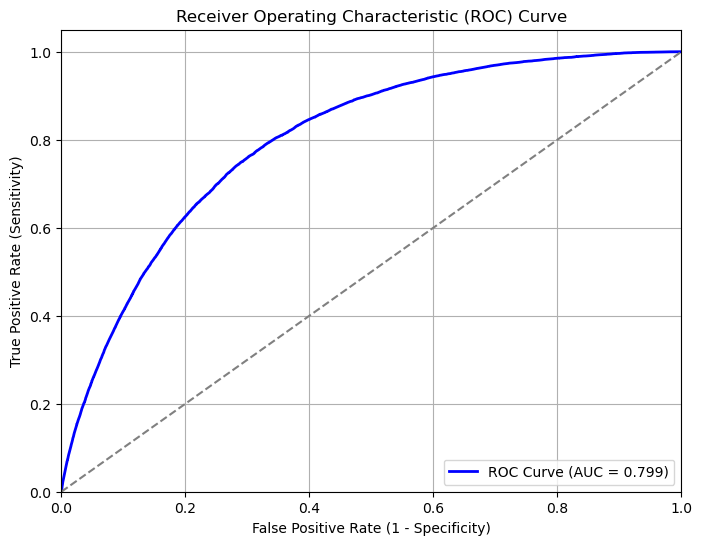

In [13]:
# Roc Curve
# The model-predicted probabilities for the positive class
y_proba = xgb.predict_proba(X_test)[:, 1]

# Calculate FPR (False Positive Rate) and TPR (True Positive Rate)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate AUC score
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [16]:
# Cross Validation
# Set up StratifiedKFold for 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate ROC AUC across folds using your model (e.g., xgb)
cv_auc_scores = cross_val_score(
    xgb,          # trained model here
    X, y,         # Features and labels
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1
)

# Print results
print("Cross-validated ROC AUC scores for each fold:")
print(np.round(cv_auc_scores, 4))

print(f"\nMean ROC AUC: {cv_auc_scores.mean():.4f}")
print(f"Standard Deviation: {cv_auc_scores.std():.4f}")


Cross-validated ROC AUC scores for each fold:
[0.8012 0.802  0.8031 0.7987 0.7989]

Mean ROC AUC: 0.8008
Standard Deviation: 0.0017


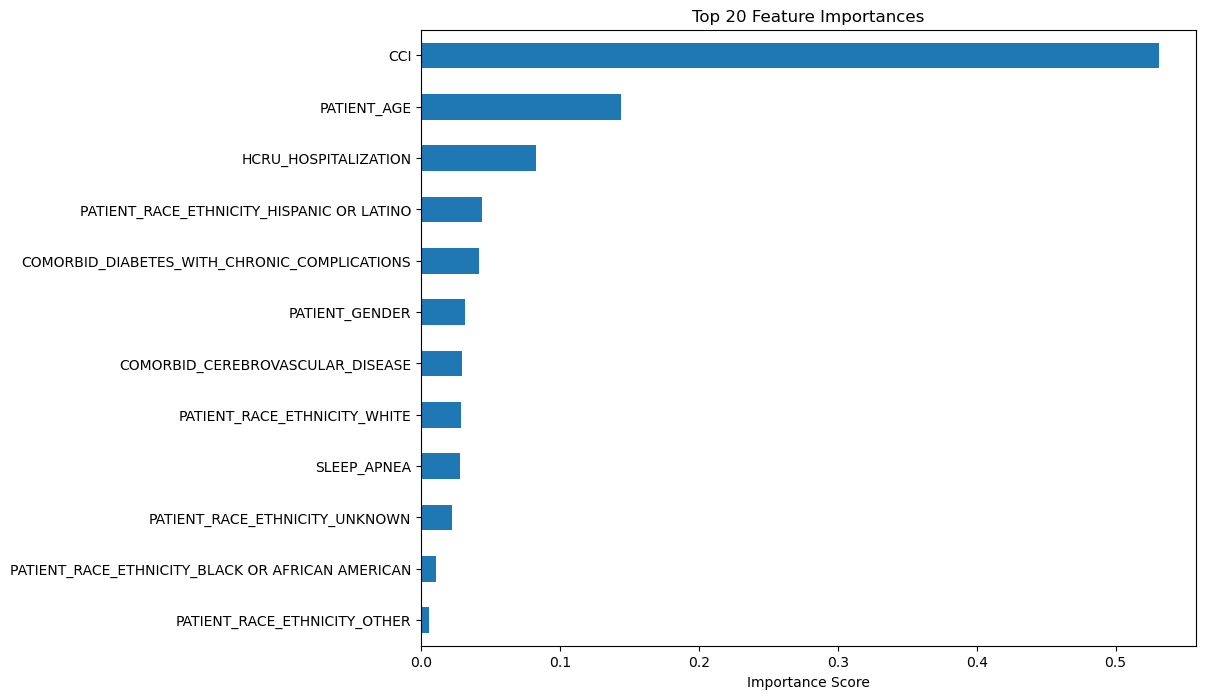


Top 10 Features:
CCI                                             0.531347
PATIENT_AGE                                     0.143884
HCRU_HOSPITALIZATION                            0.083009
PATIENT_RACE_ETHNICITY_HISPANIC OR LATINO       0.043647
COMORBID_DIABETES_WITH_CHRONIC_COMPLICATIONS    0.041705
PATIENT_GENDER                                  0.031294
COMORBID_CEREBROVASCULAR_DISEASE                0.029701
PATIENT_RACE_ETHNICITY_WHITE                    0.028383
SLEEP_APNEA                                     0.027987
PATIENT_RACE_ETHNICITY_UNKNOWN                  0.022300
dtype: float32


In [17]:
 # Plot feature importances
importances = xgb.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,8))
feat_importance.head(20).plot(kind='barh')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

print("\nTop 10 Features:")
print(feat_importance.head(10))